**Important: This notebook will only work with fastai-0.7.x. Do not try to run any fastai-1.x code from this path in the repository because it will load fastai-0.7.x**

# Random Forest Model interpretation

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [6]:
set_plot_sizes(12,14,16)

## Load in our data from last lesson

In [7]:
PATH = "data/bulldozers/"

df_raw = pd.read_feather('tmp/bulldozers-raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [8]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [9]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [10]:
df_raw

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,2,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,2,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,0,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,0,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,1,S175,...,23,3,204,False,False,False,False,False,False,1248307200
5,1139255,10.184900,1001274,4605,121,3.0,2004,508.0,2,310G,...,18,3,353,False,False,False,False,False,False,1229558400
6,1139256,9.952278,772701,1937,121,3.0,1993,11540.0,0,790ELC,...,26,3,239,False,False,False,False,False,False,1093478400
7,1139261,10.203592,902002,3539,121,3.0,2001,4883.0,0,416D,...,17,3,321,False,False,False,False,False,False,1132185600
8,1139272,9.975808,1036251,36003,121,3.0,2008,302.0,2,430HAG,...,27,3,239,False,False,False,False,False,False,1251331200
9,1139275,11.082143,1016474,3883,121,3.0,1000,20700.0,1,988B,...,9,3,221,False,False,False,False,False,False,1186617600


# Confidence based on tree variance

For model interpretation, there's no need to use the full dataset on each tree - using a subset will be both faster, and also provide better interpretability (since an overfit model will not provide much variance across trees).

In [11]:
set_rf_samples(50000)

In [12]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20621222694136043, 0.24984052506420115, 0.9111282666408849, 0.8885259597669449, 0.8940091484401843]


We saw how the model averages predictions across the trees to get an estimate - but how can we know the confidence of the estimate? One simple way is to use the standard deviation of predictions, instead of just the mean. This tells us the *relative* confidence of predictions - that is, for rows where the trees give very different results, you would want to be more cautious of using those results, compared to cases where they are more consistent. Using the same example as in the last lesson when we looked at bagging:

In [13]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 1.55 s, sys: 39.8 ms, total: 1.59 s
Wall time: 1.59 s


(9.177779105269884, 0.12429960266948936)

In [14]:
??parallel_trees

When we use python to loop through trees like this, we're calculating each in series, which is slow! We can use parallel processing to speed things up:

In [15]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 115 ms, sys: 82.1 ms, total: 198 ms
Wall time: 394 ms


(9.177779105269884, 0.12429960266948936)

We can see that different trees are giving different estimates this this auction. In order to see how prediction confidence varies, we can add this into our dataset.

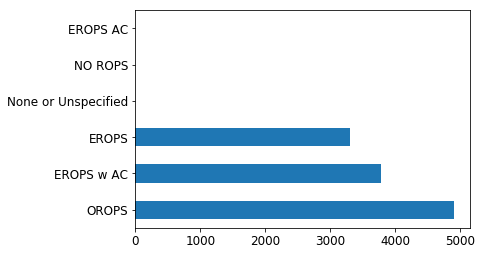

In [16]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh();

In [17]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.834593,0.275804
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.572808,0.270716
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.685475,0.222219


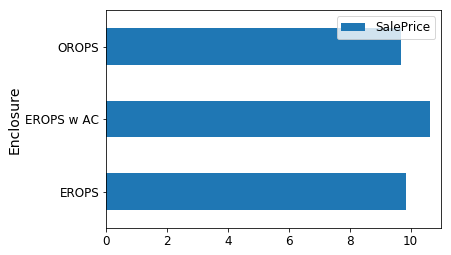

In [18]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

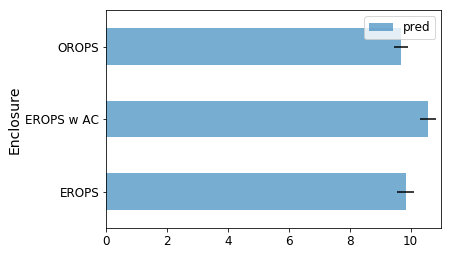

In [19]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11));

*Question*: Why are the predictions nearly exactly right, but the error bars are quite wide?

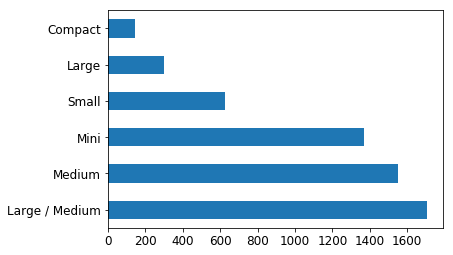

In [20]:
raw_valid.ProductSize.value_counts().plot.barh();

In [21]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.850628,0.345057
Large,10.470589,10.357342,0.381152
Large / Medium,10.691871,10.641790,0.302583
Medium,10.681511,10.612679,0.295649
Mini,9.535147,9.552059,0.238166
Small,10.324448,10.319999,0.318759


In [22]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Large             0.036800
Compact           0.035029
Small             0.030888
Large / Medium    0.028433
Medium            0.027858
Mini              0.024934
dtype: float64

# Feature importance

It's not normally enough to just to know that a model can make accurate predictions - we also want to know *how* it's making predictions. The most important way to see this is with *feature importance*.

In [23]:
rf_feat_importance??

In [24]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
5,YearMade,0.173910
37,Coupler_System,0.111774
13,ProductSize,0.098970
14,fiProductClassDesc,0.074962
2,ModelID,0.062691
63,saleElapsed,0.050720
38,Grouser_Tracks,0.047207
10,fiSecondaryDesc,0.039907
39,Hydraulics_Flow,0.036022
19,Enclosure,0.035702


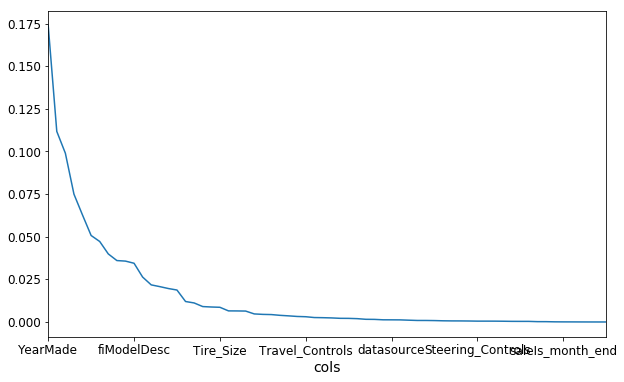

In [25]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [26]:
np.log2(200000)

17.609640474436812

In [27]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

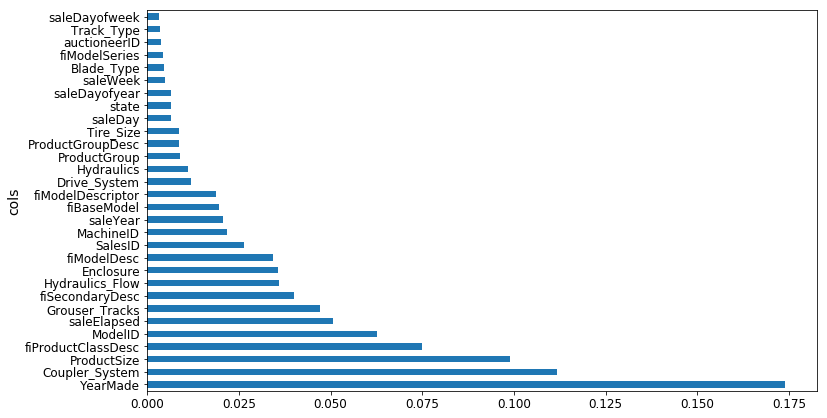

In [28]:
plot_fi(fi[:30]);

In [29]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

24

In [30]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [31]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2070670344306256, 0.24661116129439883, 0.9103899430295309, 0.8913890954716469, 0.8939518053067574]


In [32]:
??proc_df

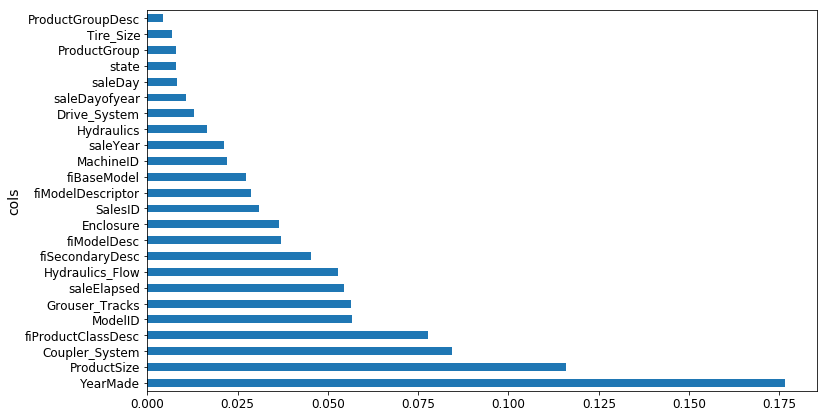

In [33]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

## One-hot encoding

proc_df's optional *max_n_cat* argument will turn some categorical variables into new columns.

For example, the column **ProductSize** which has 6 categories:

* Large
* Large / Medium
* Medium
* Compact
* Small
* Mini

gets turned into 6 new columns:

* ProductSize_Large
* ProductSize_Large / Medium
* ProductSize_Medium
* ProductSize_Compact
* ProductSize_Small
* ProductSize_Mini

and the column **ProductSize** gets removed.

It will only happen to columns whose number of categories is no bigger than the value of the *max_n_cat* argument.

Now some of these new columns may prove to have more important features than in the earlier situation, where all categories were in one column.

In [34]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.207343632458603, 0.2541293170004967, 0.9101503827389945, 0.8846659580276091, 0.8924185064413233]


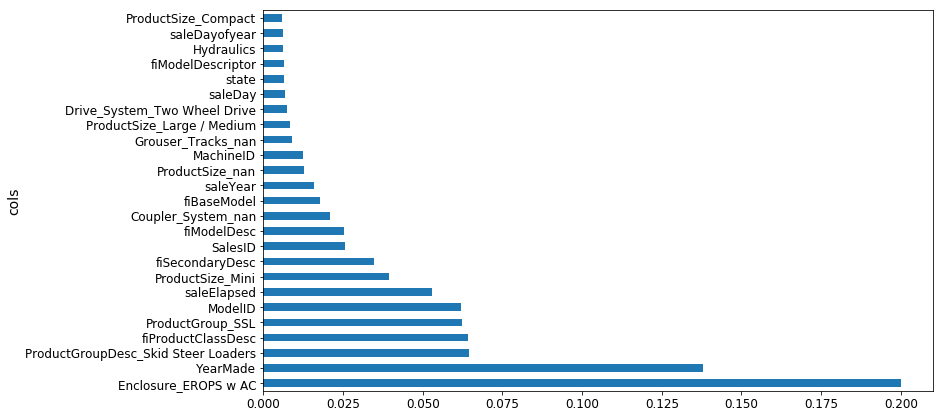

In [35]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

# Removing redundant features

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings. Let's try to remove redundent features.

In [36]:
from scipy.cluster import hierarchy as hc

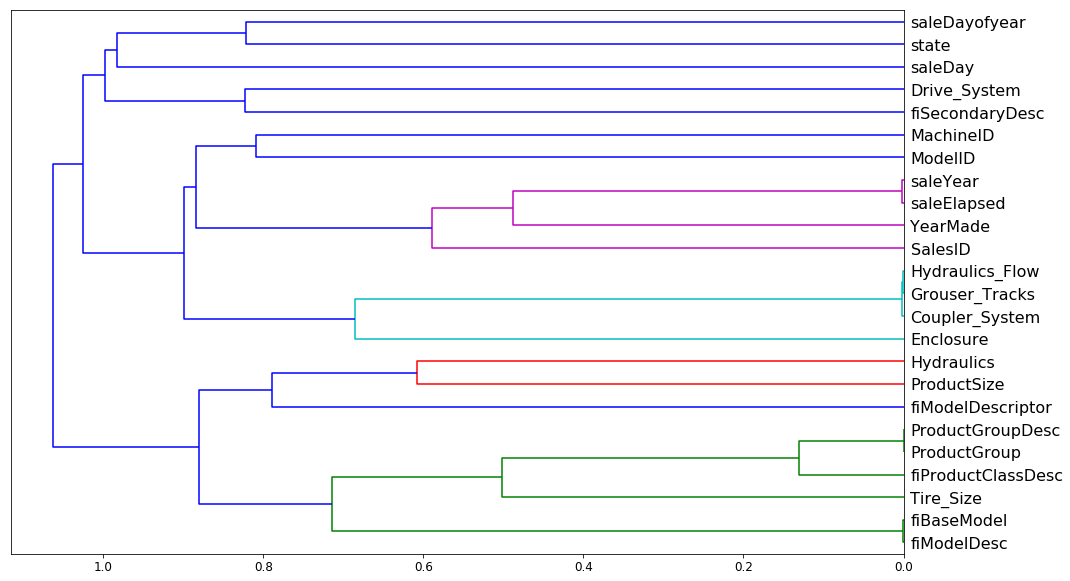

In [37]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

Let's try removing some of these related features to see if the model can be simplified without impacting the accuracy.

In [38]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

Here's our baseline.

In [39]:
get_oob(df_keep)

0.8901081241663623

Now we try removing each variable one at a time.

In [40]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.8901318402970809
saleElapsed 0.8870352997427594
fiModelDesc 0.8886534848540788
fiBaseModel 0.8887714145001339
Grouser_Tracks 0.8894096389470434
Coupler_System 0.8899341882898655


It looks like we can try one from each group for removal. Let's see what that does.

In [41]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

0.8888600929147521

Looking good! Let's use this dataframe from here. We'll save the list of columns so we can reuse it later.

In [42]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [43]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [44]:
keep_cols = np.load('tmp/keep_cols.npy')
df_keep = df_trn[keep_cols]

And let's see how this model looks on the full dataset.

In [45]:
reset_rf_samples()

In [46]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.12579959126548354, 0.2278816666180315, 0.9669255001010498, 0.9072600733587599, 0.9086021021550857]


# Partial dependence

In [47]:
from pdpbox import pdp
from plotnine import *

ModuleNotFoundError: No module named 'plotnine'

In [48]:
set_rf_samples(50000)

This next analysis will be a little easier if we use the 1-hot encoded categorical variables, so let's load them up again.

In [49]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

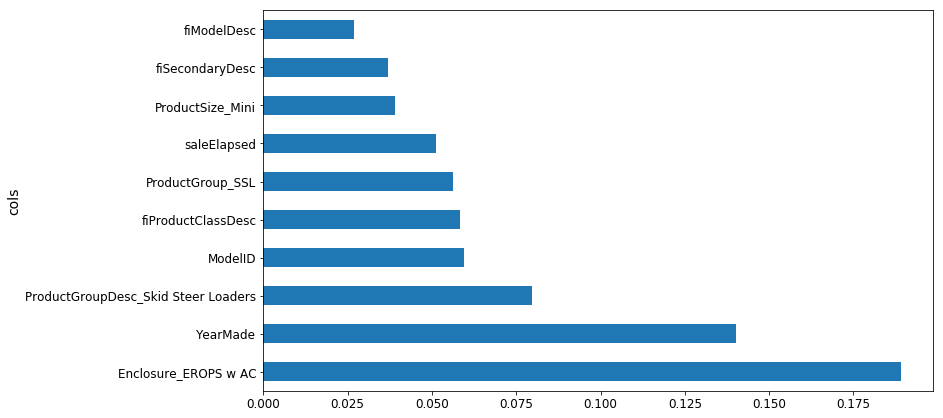

In [50]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

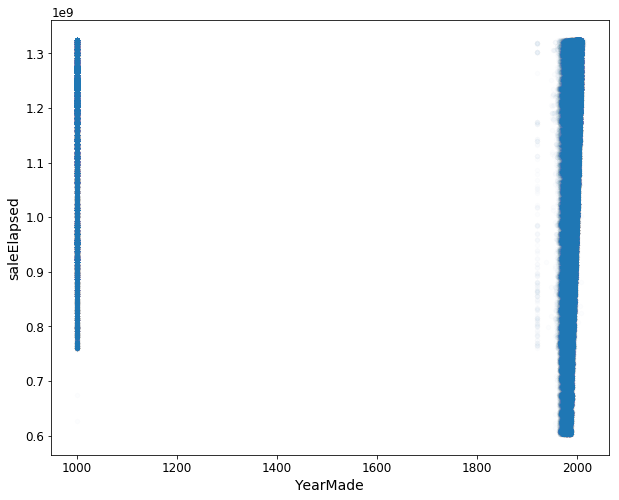

In [51]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

In [67]:
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500)

In [69]:
x_all.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
       'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
       'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
       'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
       'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
       'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier',
       'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System',
       'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
       'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
       'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'saleYear', 'saleMonth',
       'saleWeek', 'saleDay', 'saleDayofweek', 'saleDayofyear',


In [68]:
plt.scatter(x_all['YearMade'], x['SalePrice'])

KeyError: 'SalePrice'

In [57]:
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess')

NameError: name 'ggplot' is not defined

In [58]:
x = get_sample(X_train[X_train.YearMade>1930], 500)

In [59]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, x.columns, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

In [63]:
import warnings
warnings.filterwarnings("ignore")


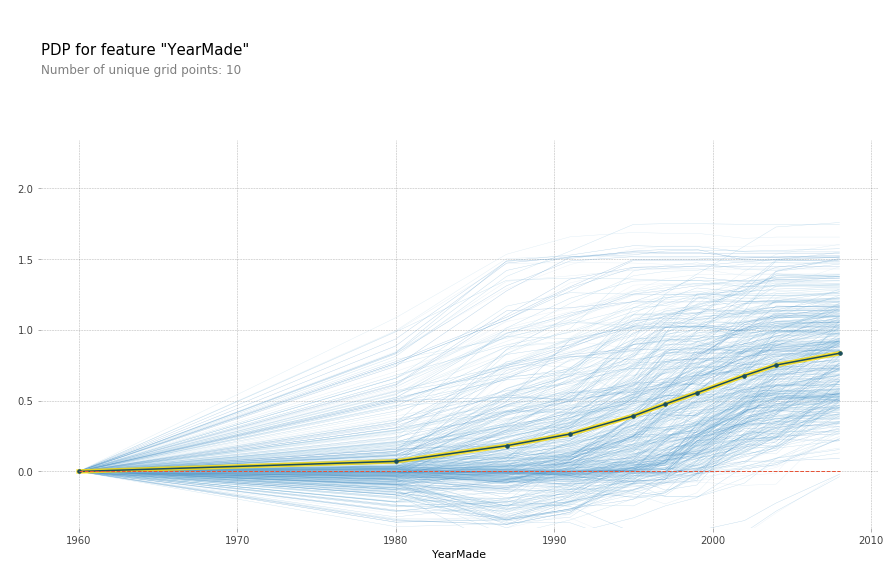

In [64]:
plot_pdp('YearMade');

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f3fd3d85dd8>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f3fd3dae358>})

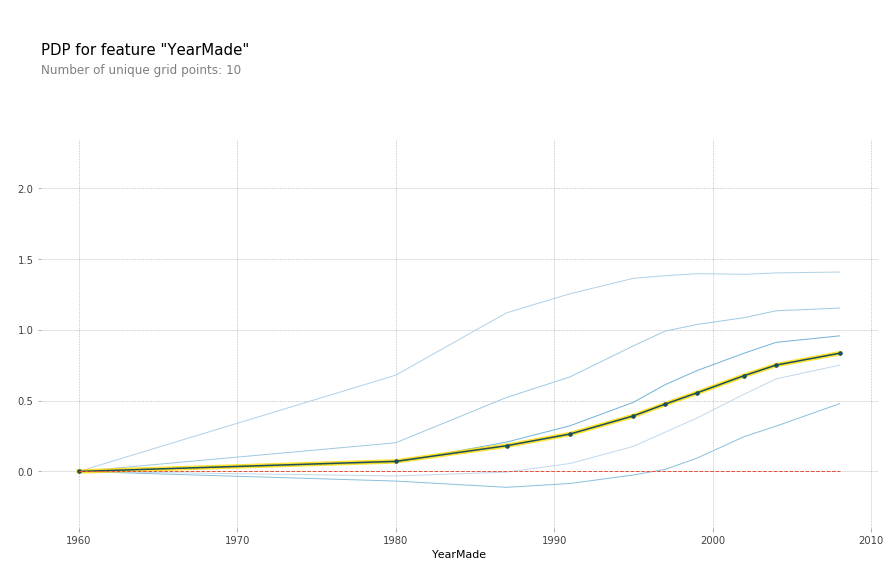

In [70]:
plot_pdp('YearMade', clusters=5)

(<Figure size 540x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f3fd3c1cfd0>,
  'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f3fd3c242b0>})

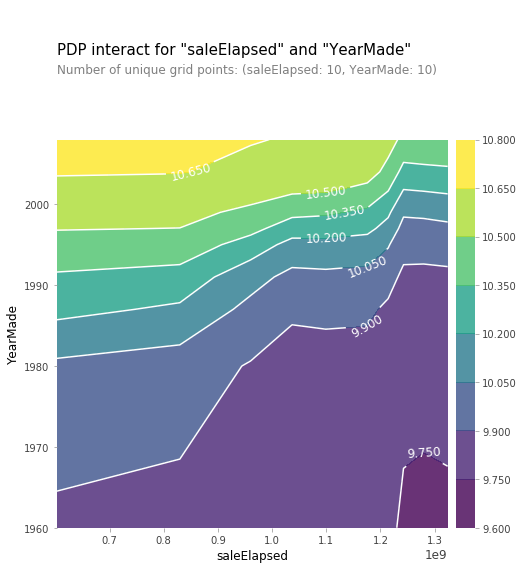

In [71]:
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(m, x, x.columns, feats)
pdp.pdp_interact_plot(p, feats)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f3fd3abb780>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f3fd3abecf8>})

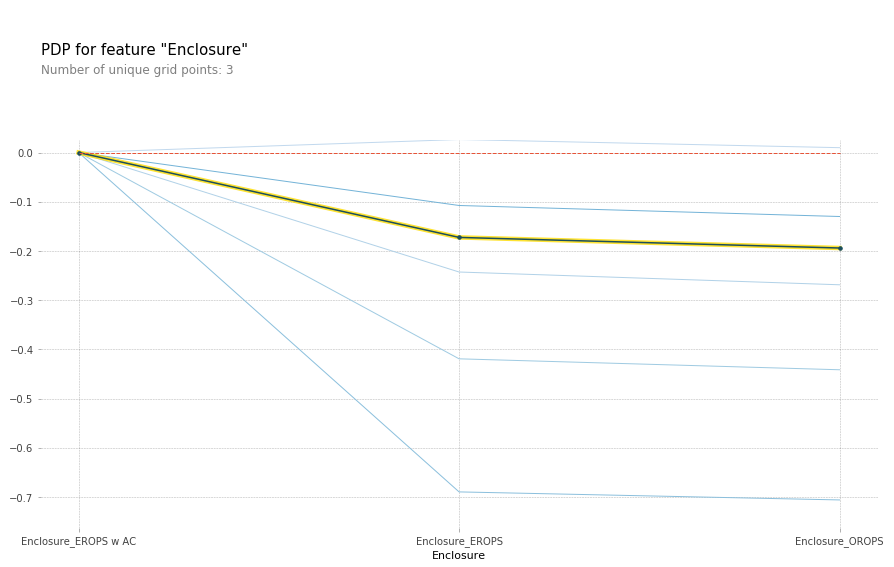

In [73]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure')

In [74]:
df_raw.YearMade[df_raw.YearMade<1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade

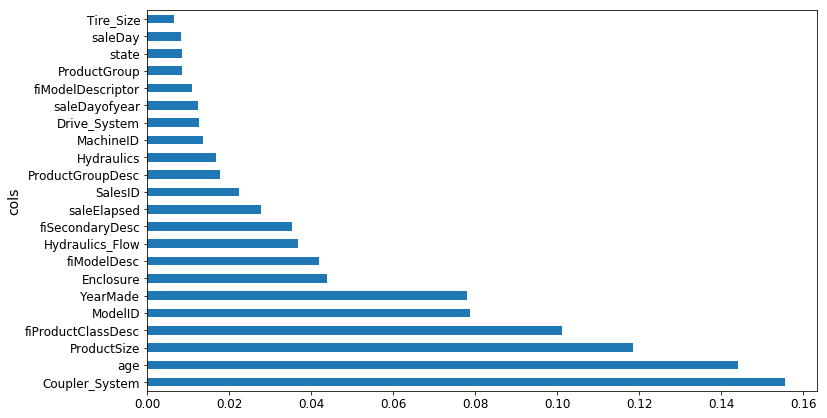

In [75]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m, df_keep));

# Tree interpreter

In [93]:
from treeinterpreter import treeinterpreter as ti

In [94]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [95]:
row = X_valid.values[None,0]; row

array([[      1999,          0,          5,         17,        665, 1284595200,          0,          0,
                 1,       3232,    4364751,    2300944,          0,          0,         12,          4,
                 4,          0,         16,         35,        259,         11]])

In [96]:
prediction, bias, contributions = ti.predict(m, row)

In [97]:
prediction[0], bias[0]

(array([9.35175]), 10.10533690756929)

In [98]:
contributions[0]

array([ 0.104  ,  0.07427, -0.55164, -0.08388,  0.06601, -0.02614, -0.05781,  0.01846, -0.04012, -0.08908,
       -0.0459 ,  0.00131, -0.00675,  0.00421,  0.01477,  0.0082 ,  0.00848, -0.01065,  0.00426,  0.00151,
       -0.00009, -0.147  ])

In [99]:
idxs = np.argsort(contributions[0])

In [100]:
idxs

array([ 2, 21,  9,  3,  6, 10,  8,  5, 17, 12, 20, 11, 19, 13, 18, 15, 16, 14,  7,  4,  1,  0])

In [101]:
df = pd.DataFrame([o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])])

In [102]:
df

,0,1,2
0,ProductSize,Mini,-0.551638
1,age,11,-0.147004
2,fiModelDesc,KX1212,-0.089077
3,fiProductClassDesc,"Hydraulic Excavator, Track - 3.0 to 4.0 Metric...",-0.083883
4,fiSecondaryDesc,NaN,-0.057810
5,SalesID,4364751,-0.045901
6,Enclosure,EROPS,-0.040122
7,saleElapsed,1284595200,-0.026141
8,Tire_Size,NaN,-0.010652
9,fiModelDescriptor,NaN,-0.006746


In [103]:
contributions[0].sum()

-0.7535833457898603

In [104]:
prediction[0] - bias[0]

array([-0.75358])

# Extrapolation

In [105]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

In [106]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9999925210345902

In [107]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
10,SalesID,0.814659
5,saleElapsed,0.140589
11,MachineID,0.039351
4,ModelID,0.001367
9,fiModelDesc,0.000845
0,YearMade,0.000739
1,Coupler_System,0.000675
20,saleDayofyear,0.000618
14,Hydraulics,0.000484
21,age,0.000223


In [108]:
feats=['SalesID', 'saleElapsed', 'MachineID']

In [109]:
(X_train[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,389125.000000,3.891250e+05,389125.000000
mean,1800.452485,1.084797e+06,1206.796148
std,595.627288,1.803913e+05,430.850552
min,1139.246000,6.009984e+05,0.000000
25%,1413.348000,9.666432e+05,1087.016000
50%,1632.093000,1.134605e+06,1273.859000
75%,2210.453000,1.234138e+06,1458.661000
max,4364.741000,1.325117e+06,2313.821000


In [110]:
(X_valid[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,12000.000000,1.200000e+04,12000.000000
mean,5786.967651,1.306609e+06,1578.049709
std,836.899608,2.497808e+04,589.497173
min,4364.751000,1.174522e+06,0.830000
25%,4408.580750,1.309219e+06,1271.225250
50%,6272.538500,1.316045e+06,1825.317000
75%,6291.792250,1.321402e+06,1907.858000
max,6333.342000,1.325203e+06,2486.330000


In [111]:
x.drop(feats, axis=1, inplace=True)

In [112]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9786674976628233

In [113]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
18,age,0.230670
0,YearMade,0.186793
17,saleDayofyear,0.159972
4,ModelID,0.078267
8,fiModelDesc,0.062350
15,saleDay,0.058607
16,state,0.058383
3,fiProductClassDesc,0.033525
5,fiSecondaryDesc,0.023480
11,Hydraulics,0.021280


In [114]:
set_rf_samples(50000)

In [115]:
feats=['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofyear']

In [116]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20762898937854532, 0.2474538471394731, 0.909902901273256, 0.8906455667156353, 0.8933799947455778]


In [117]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

SalesID
[0.20903265171953, 0.24573733643939086, 0.9086805923155848, 0.8921574205071622, 0.8925918292222258]
saleElapsed
[0.21412657956970807, 0.25358661646463126, 0.9041756271726805, 0.8851580304399319, 0.8871567109890257]
MachineID
[0.20681695007803264, 0.24522109526071115, 0.9106062646696068, 0.8926100525971737, 0.894927642619802]
age
[0.20935645207436587, 0.24787252214979108, 0.908397457997781, 0.8902752132078007, 0.8918581845642217]
YearMade
[0.20958848001747543, 0.2536898985606333, 0.9081943008731796, 0.8850644645024213, 0.8915763225059403]
saleDayofyear
[0.20886953983608356, 0.24580787718226618, 0.9088230530166705, 0.8920954975804561, 0.8928154773519789]


In [118]:
reset_rf_samples()

In [119]:
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1386655848858903, 0.21905818513288244, 0.9598142385606204, 0.9143027384010749, 0.9090996999781213]


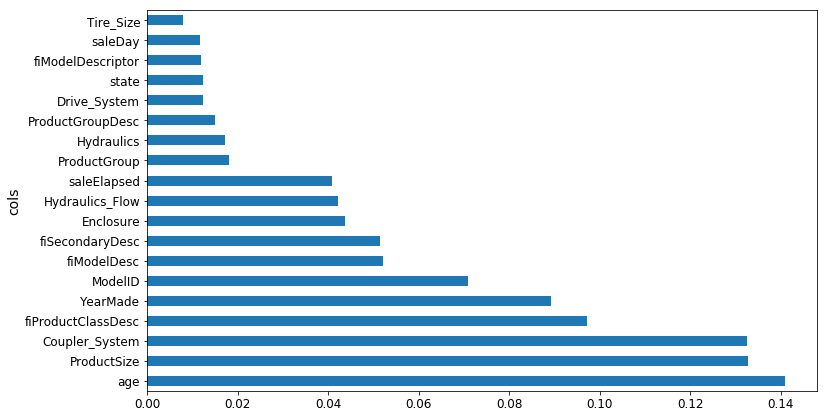

In [120]:
plot_fi(rf_feat_importance(m, X_train));

In [121]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

# Our final model!

In [122]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 4min 34s, sys: 2.31 s, total: 4min 36s
Wall time: 25.1 s
[0.08018288593784031, 0.2110412540665457, 0.9865631276101551, 0.9204605301817512, 0.9146835034410343]
